In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from gammapy.data import DataStore
from astropy.coordinates import SkyCoord
from astropy.time import Time
from agn_pipe.query import  get_exclusion_regions, query_datastore
from agn_pipe.analysis.spectral_analysis import SpectralAnalysis
import matplotlib.pyplot as plt


In [39]:
c = SkyCoord.from_name("Crab")
fname = "/raid/RAID1/VERITAS_Data/gammapy/dl3_fullenclosure_moderate2tel_runwise/"
ra = c.ra.deg
dec = c.dec.deg
search_cone = 2.0
tstart = Time("2023-01-01T00:00:00")
tstop = Time("2024-01-01T00:00:00")

# tstart = Time("2021-08-23T00:00:00") # 59449
# tstop = Time("2022-01-10T00:00:00") # 59589

obs = query_datastore(fname, ra, dec, tstart= tstart, tstop = tstop)
print (len(obs))
obs

24


[104732,
 104450,
 104451,
 104481,
 104931,
 104524,
 104684,
 104449,
 104731,
 104711,
 104760,
 104781,
 104508,
 104406,
 104933,
 104970,
 104452,
 104713,
 104480,
 104705,
 104712,
 104546,
 104737,
 104683]

In [40]:
myspec = SpectralAnalysis(fname,ra, dec, tstart = tstart, tstop= tstop, source_name="Crab")

In [41]:
myspec.scratch_path

PosixPath('analysis/31d41300-29f0-4761-ba26-0fea9de17e8d')

In [42]:
myspec.initialize_analysis()

ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '104732'.
ReflectedRegionsBackgroundMaker failed. Setting 104732 mask to False.
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '104450'.
ReflectedRegionsBackgroundMaker failed. Setting 104450 mask to False.
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '104684'.
ReflectedRegionsBackgroundMaker failed. Setting 104684 mask to False.
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '104449'.
ReflectedRegionsBackgroundMaker failed. Setting 104449 mask to False.
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '104760'.
ReflectedRegionsBackgroundMaker failed. Setting 104760 mask to False.
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '104933'.
ReflectedRegionsBack

In [43]:
myspec.setup_model("pwl")

In [44]:
myspec.dataset_stacked.models

In [45]:
myspec.fit_spectrum()

In [46]:
points = myspec.get_spectral_points(e_min = 0.1, e_max = 100)

No dataset contribute in range 46.41588833612777 TeV-100.0 TeV


In [47]:
tab = points.to_table()
tab

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,stat_scan,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float64[1],float64,float64,bool,float64[1],bool,float64[11],float64[11]
0.13949507939624212,0.10000000000000002,0.19458877175763883,3.6435343288348977e-09,3.5173446288555127e-10,4.737931424004768e-11,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,False,0.0,False,nan .. nan,0.2 .. 4.999999999999999
0.30329340116768616,0.19458877175763883,0.4727245378085489,5.413821684650419e-10,1.560854932048129e-10,4.450453498937823e-11,0.835028826471062,0.056963770166907006,0.055731968088411236,0.05821095998211767,0.9539803410129163,710.9845735542011,26.664293981918988,230.79715449496553,223.3240203857422,15.097785726677856,726.082359280879,False,231.0,True,278.8010659904771 .. 1428.3103870395714,0.2 .. 4.999999999999999
0.6594274693415538,0.4727245378085489,0.9198688719186306,8.044240176697724e-11,3.6710071595330156e-11,2.3375839969534425e-11,1.0789834328044108,0.05320633014110939,0.05236412993071071,0.054056557528225246,1.1888204221150775,1387.0901014381461,37.24365853991987,433.9399227536368,423.23724365234375,2.476037918131169,1389.5661393562773,False,434.0,True,653.7203187456148 .. 1763.6937438827329,0.2 .. 4.999999999999999
1.433742328873773,0.9198688719186306,2.234684886463062,1.1952702506598403e-11,1.6290441327625925e-11,2.1957491460501192e-11,1.0654276146582333,0.054162025192830365,0.05326950374573025,0.05506272767477083,1.1773741884113818,1369.6448881703163,37.00871367894751,401.8555206749344,394.91314697265625,1.1862575515638127,1370.8311457218801,False,402.0,True,622.6025395318572 .. 1685.575509935265,0.2 .. 4.999999999999999
3.117275456627471,2.234684886463062,4.34844587322206,1.776017300242927e-12,3.831382758114212e-12,1.1533089979158223e-11,1.064885463724688,0.09243864067426268,0.08983549182278516,0.09508086896662804,1.2604095984734591,489.42432225195535,22.12293656484047,136.9013388399491,134.9863739013672,1.6134722232856404,491.03779447524096,False,137.0,True,216.59370329387247 .. 578.5071262156979,0.2 .. 4.999999999999999
6.777651797534069,4.34844587322206,10.563903801010005,2.638932449812836e-13,1.7002123208246994e-12,1.0833310163853006e-11,0.8299761598241263,0.1162358427392133,0.1109459800844471,0.12165478356886208,1.0843688751202525,172.0441070073761,13.116558504706031,51.899086914042975,51.539031982421875,22.341007445688106,194.38511445306423,False,52.0,True,87.85287649814828 .. 354.17896802964117,0.2 .. 4.999999999999999
14.736125994561542,10.563903801010005,20.556170656043893,3.9211129721104843e-14,3.998764698961316e-13,5.690155504174977e-12,0.5894734254650226,0.2011852800557656,0.1793189123163768,0.22370470631591335,1.0838028841256506,31.485500574291947,5.611194219975989,9.015710171581183,8.816165924072266,0.0022182408485480476,31.487718815140497,False,9.0,True,6.971864031608325 .. 93.77834501220691,0.2 .. 4.999999999999999
30.889042098927565,20.556170656043893,46.415888336127765,6.373531738649839e-15,1.6989529276680734e-13,4.981385165376913e-12,0.5402413297698568,0.3119084552588677,0.2550236053933943,0.37464662853473074,1.4241542367875155,10.1101914164017,3.1796527194650834,2.9997058284880254,2.9997057914733887,2.3254086399350395,12.435600056336739,False,3.0,True,4.509200195659151 .. 38.50022680845605,0.2 .. 4.999999999999999


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

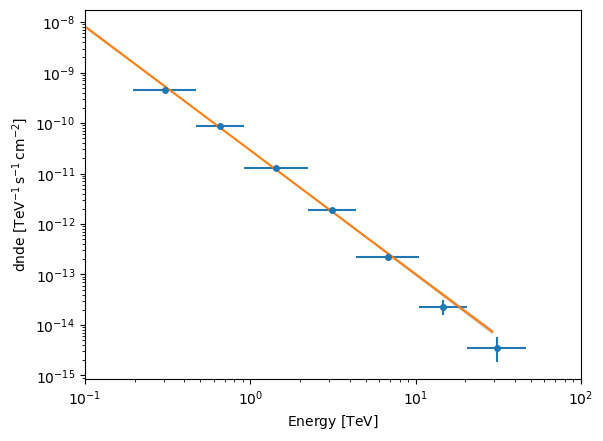

In [48]:
from astropy import units as u
fig, ax = plt.subplots()
points.plot(sed_type="dnde")
myspec.model.spectral_model.plot([0.1 * u.TeV, 30 * u.TeV])
myspec.model.spectral_model.plot_error([0.1 * u.TeV, 30 * u.TeV])


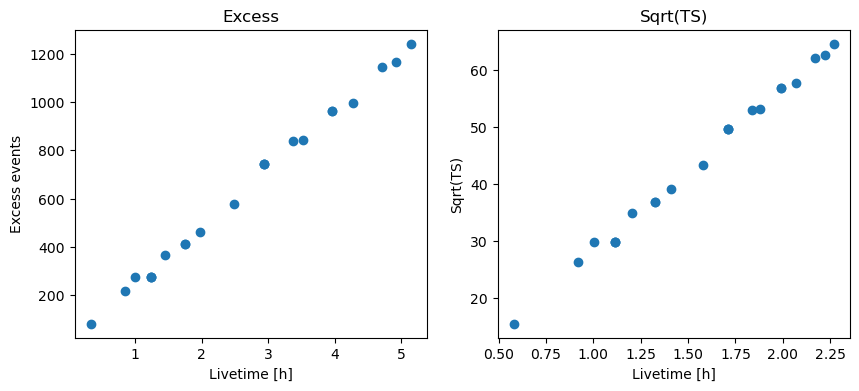

In [49]:
import numpy as np

fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    myspec.info_table["livetime"].to("h"),
    myspec.info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    np.sqrt(myspec.info_table["livetime"].to("h")),
    myspec.info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")
plt.show()

In [50]:
print (f"Total significance: {myspec.info_table['sqrt_ts'][-1]:0.2f}")

Total significance: 64.61


In [53]:
my_lc_daily = myspec.run_lightcurve(1)
my_lc_weekly = myspec.run_lightcurve(7)
# my_lc_monthly = myspec.run_lightcurve(28)
# my_lc_yearly = myspec.run_lightcurve(365)


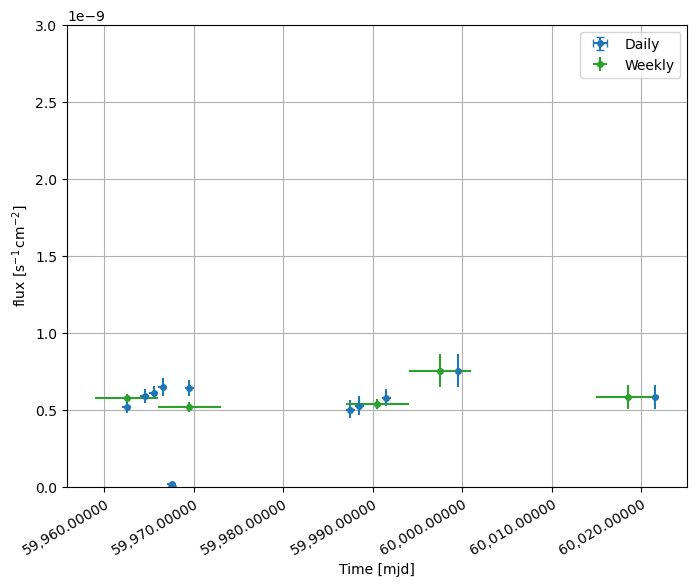

In [54]:
plt.figure(figsize=(8, 6))
my_lc_daily.plot(marker="o", sed_type="flux",time_format="mjd", label = "Daily")
my_lc_weekly.plot(marker="o", color = "C2", sed_type="flux",time_format="mjd", label = "Weekly")
# my_lc_monthly.plot(marker="o", color = "C3",  sed_type="flux",time_format="mjd", label = "Monthly")
plt.yscale('linear')
# plt.ylim(-0.1e-10, 1e-10)
plt.ylim(0, 0.3e-8)

plt.grid()

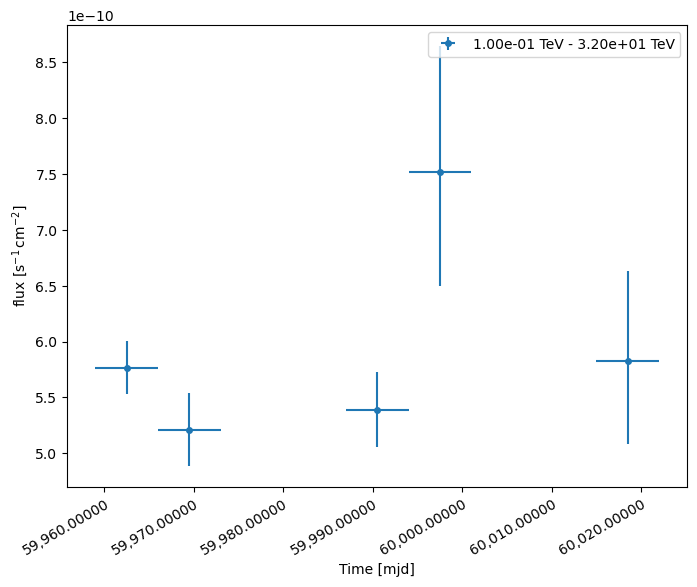

In [55]:
plt.figure(figsize=(8, 6))
my_lc_weekly.plot(marker="o", sed_type="flux",time_format="mjd")
plt.yscale('linear')

In [56]:
# plt.figure(figsize=(8, 6))
# my_lc_monthly.plot(marker="o", sed_type="flux",time_format="mjd")
# plt.yscale('linear')

In [78]:
my_lc_daily.to_table(format="lightcurve")

time_min,time_max,e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,stat_scan,norm_scan
,,TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,24]","float64[1,24]",float64[1],float64[1],bool[1],"float64[1,24]",bool[1],"float64[1,11]","float64[1,11]"
59962.00080074074,59963.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,0.9173087349025683,0.07262686195264804,0.07078020892558996,0.07449824523683475,1.0700964788651603,563.6815227896365,23.741978072385553,167.9497213963308 .. nan,163.94346618652344 .. nan,18.68493894339139,582.3664617330279,False,168.0 .. nan,True,239.27819813415428 .. 914.6389273815419,0.2 .. 4.999999999999999
59964.00080074074,59965.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.0359528885101232,0.0788055023572058,0.07688212113662185,0.08075954627502235,1.2014626493654559,574.1535861147589,23.961502167325797,nan .. nan,nan .. nan,33.21687038467223,607.3704564994312,False,nan .. nan,True,299.0626030784242 .. 825.9655714552882,0.2 .. 4.999999999999999
59965.00080074074,59966.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.0797159907985119,0.06854181918335517,0.06714299367268528,0.06995697460958805,1.2224992257665777,842.5134812256387,29.026082774388257,nan .. nan,nan .. nan,47.6545034815788,890.1679847072174,False,nan .. nan,True,444.9128687139764 .. 1107.686728723707,0.2 .. 4.999999999999999
59966.00080074074,59967.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.141733331685549,0.10654337275788135,0.10334588074431506,0.10979480251760032,1.3679380587011651,344.952184004467,18.57288841307315,nan .. nan,nan .. nan,20.574018997720927,365.5262030021879,False,nan .. nan,True,209.62839066331898 .. 464.34181890392193,0.2 .. 4.999999999999999
59967.00080074074,59968.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,nan,nan,0.009315945625635945,0.009315945625635943,0.03726378250253756,-1.906791764125792e-13,-0.0,nan .. nan,nan .. nan,1.906791764125792e-13,0.0,True,nan .. nan,False,21.46856669597512 .. 536.7141673993777,0.2 .. 4.999999999999999
59969.00080074074,59970.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.1267847506077417,0.0930801573733575,0.09059981318851773,0.09559678825170503,1.3230878248045754,537.4512894243641,23.182995695646497,nan .. nan,nan .. nan,13.749987807424484,551.2012772317886,False,nan .. nan,True,261.0152105150016 .. 593.0393632669079,0.2 .. 4.999999999999999
59987.00080074074,59988.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,0.8851842221152382,0.10421805102987344,0.10029599458623545,0.10821937476980033,1.1097774799268256,244.48662261277383,15.636068003586255,nan .. nan,nan .. nan,28.15646892374367,272.6430915365175,False,nan .. nan,True,123.84752683529481 .. 457.44253608667384,0.2 .. 4.999999999999999
59988.00080074074,59989.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,0.9261858768044751,0.108952265996049,0.10493834211899299,0.11304849767909869,1.1597953560842331,208.6841826374232,14.445905393481683,nan .. nan,nan .. nan,58.00444663230395,266.68862926972713,False,nan .. nan,True,153.80144973170218 .. 473.

In [77]:
my_lc_weekly.to_table(format="lightcurve")

time_min,time_max,e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,stat_scan,norm_scan
,,TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,24]","float64[1,24]",float64[1],float64[1],bool[1],"float64[1,24]",bool[1],"float64[1,11]","float64[1,11]"
59959.00080074074,59966.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.0170103509350106,0.042218226202895136,0.04166486835526573,0.042798453341275966,1.1040370809753333,1977.6580995641275,44.47086798752783,0.0 .. nan,0.0 .. nan,102.2468033755491,2079.9049029396765,False,0.0 .. nan,True,983.253669926555 .. 2848.2912275605368,0.2 .. 4.999999999999999
59966.00080074074,59973.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,0.9182786193551351,0.0571599975106062,0.05602133884116825,0.05831085102393612,1.0372263187666846,773.0641935110807,27.804031965006097,nan .. nan,nan .. nan,143.66328672289583,916.7274802339765,False,nan .. nan,True,492.1121678742957 .. 1594.0953495702076,0.2 .. 4.999999999999999
59987.00080074074,59994.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,0.9498240262152541,0.05963236560831919,0.05842195396741712,0.06083946311641597,1.073749927520646,827.0692081546161,28.75881096559133,nan .. nan,nan .. nan,157.29491901282734,984.3641271674435,False,nan .. nan,True,513.7239893629975 .. 1520.553693896894,0.2 .. 4.999999999999999
59994.00080074074,60001.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.3266630305970006,0.18966019818753638,0.1809667959258121,0.1985746868988958,1.7420664859930608,175.87784288199498,13.261894392657295,nan .. nan,nan .. nan,13.148363004533175,189.02620588652815,False,nan .. nan,True,106.80621055843879 .. 156.2523499178379,0.2 .. 4.999999999999999
60015.00080074074,60022.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.0276477727650488,0.13619884136694896,0.13070316786222536,0.14200180078152225,1.3240482428645541,180.03374390790376,13.417665367265043,nan .. nan,nan .. nan,21.57434807875062,201.6080919866544,False,nan .. nan,True,105.99086646039785 .. 290.7147907482008,0.2 .. 4.999999999999999
60022.00080074074,60029.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,nan,nan,nan,nan,nan,nan,nan,nan .. nan,nan .. 0.0,0.0,0.0,False,nan .. 0.0,False,nan .. nan,0.2 .. 4.999999999999999


In [58]:
# my_lc_monthly.to_table(format="lightcurve")

In [60]:
# my_lc_yearly.to_table(format="lightcurve")

In [61]:
# my_lc_yearly = myspec.run_lightcurve(365)


In [62]:
tab_lc = my_lc_weekly.to_table(format="lightcurve")

In [63]:
tab_lc

time_min,time_max,e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,stat_scan,norm_scan
,,TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,24]","float64[1,24]",float64[1],float64[1],bool[1],"float64[1,24]",bool[1],"float64[1,11]","float64[1,11]"
59959.00080074074,59966.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.0170103509350106,0.042218226202895136,0.04166486835526573,0.042798453341275966,1.1040370809753333,1977.6580995641275,44.47086798752783,0.0 .. nan,0.0 .. nan,102.2468033755491,2079.9049029396765,False,0.0 .. nan,True,983.253669926555 .. 2848.2912275605368,0.2 .. 4.999999999999999
59966.00080074074,59973.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,0.9182786193551351,0.0571599975106062,0.05602133884116825,0.05831085102393612,1.0372263187666846,773.0641935110807,27.804031965006097,nan .. nan,nan .. nan,143.66328672289583,916.7274802339765,False,nan .. nan,True,492.1121678742957 .. 1594.0953495702076,0.2 .. 4.999999999999999
59987.00080074074,59994.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,0.9498240262152541,0.05963236560831919,0.05842195396741712,0.06083946311641597,1.073749927520646,827.0692081546161,28.75881096559133,nan .. nan,nan .. nan,157.29491901282734,984.3641271674435,False,nan .. nan,True,513.7239893629975 .. 1520.553693896894,0.2 .. 4.999999999999999
59994.00080074074,60001.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.3266630305970006,0.18966019818753638,0.1809667959258121,0.1985746868988958,1.7420664859930608,175.87784288199498,13.261894392657295,nan .. nan,nan .. nan,13.148363004533175,189.02620588652815,False,nan .. nan,True,106.80621055843879 .. 156.2523499178379,0.2 .. 4.999999999999999
60015.00080074074,60022.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.0276477727650488,0.13619884136694896,0.13070316786222536,0.14200180078152225,1.3240482428645541,180.03374390790376,13.417665367265043,nan .. nan,nan .. nan,21.57434807875062,201.6080919866544,False,nan .. nan,True,105.99086646039785 .. 290.7147907482008,0.2 .. 4.999999999999999
60022.00080074074,60029.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,nan,nan,nan,nan,nan,nan,nan,nan .. nan,nan .. 0.0,0.0,0.0,False,nan .. 0.0,False,nan .. nan,0.2 .. 4.999999999999999


In [64]:
# my_lc_yearly.plot(sed_type="flux",time_format="mjd")
# # my_lc_yearly.plot_ts_profiles()
# plt.yscale('linear')

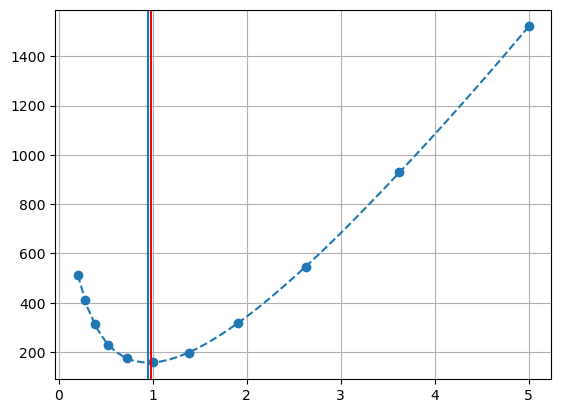

In [66]:
from scipy.interpolate import interp1d
indx = 2

plt.plot(tab_lc[indx]["norm_scan"][0], tab_lc[indx]["stat_scan"][0], "C0o")
inter = interp1d(tab_lc[indx]["norm_scan"][0], tab_lc[indx]["stat_scan"][0], kind = "quadratic")
norm_range = np.linspace(0.201,4.999)
plt.plot(norm_range,inter(norm_range), "C0--")
amin = np.argmin(inter(norm_range))

plt.axvline(tab_lc[indx]['norm'])
plt.axvline(norm_range[amin], color = "r")
plt.grid()

In [69]:
from astropy.table import Table
from typing import Tuple
from scipy.stats import chi2
def get_variability_index(tab : Table) -> Tuple[float, int]:
    """Compute the variability index of a set of light curves.
    
    Parameters:
    -----------
    tab_lc: astropy Table of light curve measurements includeing likelihood profiles
    
    
    Returns:
    --------
    ts_var: float Variability index
    ndf: int Number of degrees of freedom
            
    """

    local_max = []
    norm_range = np.linspace(0.201,4.999, 1000)
    total_prof = np.zeros(len(norm_range))
    for i in range(len(tab)):
        inter = interp1d(tab[i]["norm_scan"][0], tab[i]["stat_scan"][0], kind = "quadratic")
        
        # Get the maximum of the interpolated profile
        local_max.append(np.min(inter(norm_range)))
        # Record the total
        total_prof += inter(norm_range)


    # Likelihood of the global maximum (minimum -2 logl)
    global_max = np.min(total_prof)
    # Get the likelihood of the free maximum (minimum -2 logl)
    free_max = np.sum(local_max)
    # Variability index
    ts_var = global_max - free_max
    # ndf = n_points - 1
    return ts_var, len(tab) -1



def get_variability_probability(ts_var: float, ndf: int) -> float:
    """Compute the probability of the variability index.
    
    Parameters:
    -----------
    ts_var: float Variability index
    ndf: int Number of degrees of freedom
            
    Returns:
    --------
    prob: float Probability of the variability index
            
    """
    prob = chi2.sf(ts_var, ndf)
    return prob


def get_change_points(tab, threshold = 0.005):

    n_obs = len(tab)
    print (n_obs)
    last_change_point = 0
    change_points = [0]

    while last_change_point < n_obs:
        change_point = None
        for i in range(last_change_point, n_obs):
            # print (i)
            ts_var, ndf = get_variability_index(tab[last_change_point:i+1])
            prob = get_variability_probability(ts_var, ndf)
            # print (prob, ts_var, ndf)
            if prob < threshold:
                # print (f"Change point at {i}")
                change_points.append(i)
                change_point = i
                last_change_point = i
                break
            
        if change_point is None:
            # print ("No change point found")
            break
        # last_change_point = n_obs
        # break
    change_points.append(n_obs-1)
    return change_points

In [79]:
change_points = get_change_points(my_lc_daily.to_table(format="lightcurve"))
change_points

13


[0, 4, 5, 12]

time_min,time_max,e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,stat_scan,norm_scan
,,TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,24]","float64[1,24]",float64[1],float64[1],bool[1],"float64[1,24]",bool[1],"float64[1,11]","float64[1,11]"
59962.00080074074,59963.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,0.9173087349025683,0.07262686195264804,0.07078020892558996,0.07449824523683475,1.0700964788651603,563.6815227896365,23.741978072385553,167.9497213963308 .. nan,163.94346618652344 .. nan,18.68493894339139,582.3664617330279,False,168.0 .. nan,True,239.27819813415428 .. 914.6389273815419,0.2 .. 4.999999999999999
59964.00080074074,59965.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.0359528885101232,0.0788055023572058,0.07688212113662185,0.08075954627502235,1.2014626493654559,574.1535861147589,23.961502167325797,nan .. nan,nan .. nan,33.21687038467223,607.3704564994312,False,nan .. nan,True,299.0626030784242 .. 825.9655714552882,0.2 .. 4.999999999999999
59965.00080074074,59966.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.0797159907985119,0.06854181918335517,0.06714299367268528,0.06995697460958805,1.2224992257665777,842.5134812256387,29.026082774388257,nan .. nan,nan .. nan,47.6545034815788,890.1679847072174,False,nan .. nan,True,444.9128687139764 .. 1107.686728723707,0.2 .. 4.999999999999999
59966.00080074074,59967.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.141733331685549,0.10654337275788135,0.10334588074431506,0.10979480251760032,1.3679380587011651,344.952184004467,18.57288841307315,nan .. nan,nan .. nan,20.574018997720927,365.5262030021879,False,nan .. nan,True,209.62839066331898 .. 464.34181890392193,0.2 .. 4.999999999999999
59967.00080074074,59968.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,nan,nan,0.009315945625635945,0.009315945625635943,0.03726378250253756,-1.906791764125792e-13,-0.0,nan .. nan,nan .. nan,1.906791764125792e-13,0.0,True,nan .. nan,False,21.46856669597512 .. 536.7141673993777,0.2 .. 4.999999999999999
59969.00080074074,59970.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,1.1267847506077417,0.0930801573733575,0.09059981318851773,0.09559678825170503,1.3230878248045754,537.4512894243641,23.182995695646497,nan .. nan,nan .. nan,13.749987807424484,551.2012772317886,False,nan .. nan,True,261.0152105150016 .. 593.0393632669079,0.2 .. 4.999999999999999
59987.00080074074,59988.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,0.8851842221152382,0.10421805102987344,0.10029599458623545,0.10821937476980033,1.1097774799268256,244.48662261277383,15.636068003586255,nan .. nan,nan .. nan,28.15646892374367,272.6430915365175,False,nan .. nan,True,123.84752683529481 .. 457.44253608667384,0.2 .. 4.999999999999999
59988.00080074074,59989.00080074074,1.789961539647311,0.10000000000000002,32.039623134165716,6.932490395217006e-12,5.668683528992102e-10,1.6821499451428771e-10,0.9261858768044751,0.108952265996049,0.10493834211899299,0.11304849767909869,1.1597953560842331,208.6841826374232,14.445905393481683,nan .. nan,nan .. nan,58.00444663230395,266.68862926972713,False,nan .. nan,True,153.80144973170218 .. 473.

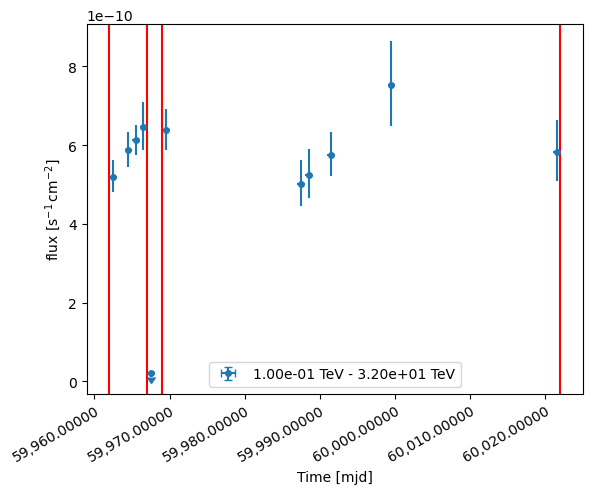

In [80]:
my_lc_daily.plot(sed_type="flux",time_format="mjd")
# my_lc_yearly.plot_ts_profiles()
plt.yscale('linear')
for cp in change_points:
    plt.axvline(my_lc_daily.to_table()[cp]["time_min"], color = "r")
my_lc_daily.to_table(format="lightcurve")

In [73]:
from scipy.stats import chi2
ts_var, ndf = get_variability_index(tab_lc[6:-2])
ax = fig.gca()
ax.grid()
ax.set_ylim(0, 10)
ax.set_xlim(0, 5)
print (ts_var, ndf, chi2.sf(ts_var, ndf))

0.0 -1 nan


In [ ]:
from astropy.stats import bayesian_blocks
help(bayesian_blocks)

Help on function bayesian_blocks in module astropy.stats.bayesian_blocks:

bayesian_blocks(t, x=None, sigma=None, fitness='events', **kwargs)
    Compute optimal segmentation of data with Scargle's Bayesian Blocks.
    
    This is a flexible implementation of the Bayesian Blocks algorithm
    described in Scargle 2013 [1]_.
    
    Parameters
    ----------
    t : array-like
        data times (one dimensional, length N)
    x : array-like, optional
        data values
    sigma : array-like or float, optional
        data errors
    fitness : str or object
        the fitness function to use for the model.
        If a string, the following options are supported:
    
        - 'events' : binned or unbinned event data.  Arguments are ``gamma``,
          which gives the slope of the prior on the number of bins, or
          ``ncp_prior``, which is :math:`-\ln({\tt gamma})`.
        - 'regular_events' : non-overlapping events measured at multiples of a
          fundamental tick rat

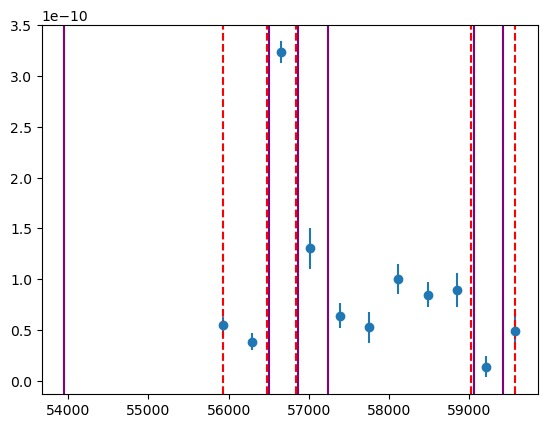

In [ ]:
mjd = tab_lc["time_min"]
flux = (tab_lc["ref_flux"] * tab_lc["norm"]).value[:,0]
flux_err = (tab_lc["ref_flux"] * tab_lc["norm_err"]).value[:,0]

mjd = mjd [3:]
flux = flux[3:]
flux_err = flux_err[3:]

plt.errorbar(mjd, flux, yerr=flux_err, fmt="o")


blocks = bayesian_blocks(mjd, flux, sigma = flux_err, fitness="measures")
[plt.axvline(b, color="r", linestyle="--") for b in blocks];
# [plt.axvline(, color="r", linestyle="--") for b in blocks];
for cp in change_points:
    plt.axvline(tab_lc[cp]["time_min"] - 150, color = "purple")

In [ ]:
tab_lc

time_min,time_max,e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,stat_scan,norm_scan
,,TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,238]","float64[1,238]",float64[1],float64[1],bool[1],"float64[1,238]",bool[1],"float64[1,11]","float64[1,11]"
54101.000754444445,54466.000754444445,1.789961539647311,0.10000000000000002,32.039623134165716,1.3450333511891988e-13,1.482936992444965e-10,2.4385945910013407e-11,0.0006095341775339365,0.01937823570945832,nan,0.37841993377151567,0.7821426529616142,-0.0003057047355916609,0.0,nan .. nan,nan .. nan,12.518422441424143,12.518116736688551,True,nan .. nan,True,12.862184234093291 .. 73.07917463082359,0.2 .. 4.999999999999999
54466.000754444445,54831.000754444445,1.789961539647311,0.10000000000000002,32.039623134165716,1.3450333511891988e-13,1.482936992444965e-10,2.4385945910013407e-11,0.4224655212292756,0.2955505063966719,nan,0.32739560022742,1.1232454449651637,3.9021989315232553,1.9753984234891084,nan .. nan,nan .. nan,18.843608874915546,22.7458078064388,True,nan .. nan,True,19.610471728225527 .. 85.0334764132297,0.2 .. 4.999999999999999
55561.000766018515,55926.000766018515,1.789961539647311,0.10000000000000002,32.039623134165716,1.3450333511891988e-13,1.482936992444965e-10,2.4385945910013407e-11,nan,nan,0.03350133832397354,0.033501338323973444,0.11658536024255445,-0.00017573064721432274,-0.0,nan .. nan,nan .. nan,76.59910782163638,76.59893209098917,True,nan .. nan,False,84.22947398913192 .. 546.0319139732877,0.2 .. 4.999999999999999
55926.000766018515,56291.00077759259,1.789961539647311,0.10000000000000002,32.039623134165716,1.3450333511891988e-13,1.482936992444965e-10,2.4385945910013407e-11,0.3670254639458603,0.05800116925989378,0.056519535355394494,0.059188991305557305,0.4880729047486191,60.05816551761387,7.749720350929695,nan .. nan,nan .. nan,218.01879882538543,278.0769643429993,False,nan .. nan,True,227.82022348726767 .. 1733.7907809770952,0.2 .. 4.999999999999999
56291.00077759259,56656.00077759259,1.789961539647311,0.10000000000000002,32.039623134165716,1.3450333511891988e-13,1.482936992444965e-10,2.4385945910013407e-11,0.2589376952605952,0.05406833530817947,0.05254966377146948,0.05506901281911669,0.3716866755273507,32.575398369015176,5.7074861689727445,nan .. nan,nan .. nan,207.716625779929,240.29202414894417,False,nan .. nan,True,208.9854805077398 .. 1786.454728971314,0.2 .. 4.999999999999999
56656.00077759259,57021.00077759259,1.789961539647311,0.10000000000000002,32.039623134165716,1.3450333511891988e-13,1.482936992444965e-10,2.4385945910013407e-11,2.1825375343497377,0.07125754214632031,0.07065643516231557,0.07187015838331767,2.3276608335067177,2109.3173142516716,45.92730467000727,nan .. nan,nan .. nan,1467.8819930905747,3577.1993073422464,False,nan .. nan,True,3006.174384762662 .. 2420.8328562568345,0.2 .. 4.999999999999999
57021.00077759259,57386.00078916667,1.789961539647311,0.10000000000000002,32.039623134165716,1.3450333511891988e-13,1.482936992444965e-10,2.4385945910013407e-11,0.8786651094846404,0.13779241653161056,0.13292074796190753,0.14169671729669595,1.170800232586132,76.81434112742791,8.764379106783773,nan .. nan,nan .. nan,114.74853569138672,191.56287681881463,False,nan .. nan,True,153.59941687225094 .. 433.65841579046713,0.2 .. 4.999999999999999
57386.00078916667,57751.00078916667,1.789961539647311,0.10000000000000002,32.039623134165716,1.3450333511891988e-13,1.482936992444965e-10,2.4385945910013407e-11,0.43174360619969526,0.0843954108657425,0.08099389977079308,0.08783756890225121,0.6144008284889259,40.003259055882495,6.324812966079115,nan .. nan,nan .. nan,104.78050695906066,144.78376601494315,False,nan .. nan,True,114.26814320080771 .. 735.6177690607948,0.2 .. 4.9999999999